# SIR epidemic model - [data assimilation]

This notebook is the second part of inspecting SIR epidemic model. 
Here we will perform epidemic data assimilation with proposed numerical model using manually implemented 4D-Var method in TensorFlow.

## 4D-Var method

Data assimilation is the process of optimizint the fit between gathered data and some prior (theoretical or based on previous measure).

`4D-Var` is one of the methods for data assimilation - it widely used for weather forecast as a successor of `3D-Var` method. 

<img src="https://i.ibb.co/sWLCYSK/Andersson-NL115-figure-1-box-754px.png" width="400">

`4D-Var` loss for $x$ model parameters is defined:

$$J(x) = (x-x_b)^T \boldsymbol{B}^{-1} (x-x_b) + \sum_{i=0}^{n}(y_i-\mathcal{H}_i(x_i))^T \boldsymbol{R}_i^{-1} (y_i-\mathcal{H}_i(x_i))$$

where: 
- $x_b$ - our prior parameters
- $\boldsymbol{B}$ - a background error covariance
- $\boldsymbol{R}$ - a observational error covariance
- $y$ - observation data
- $\mathcal{H}$ - operator that transforms input space vector into output space

`3D-Var` method assumed that all observed data happened at one fixed point of time for given assimilation window. So when performing DA for weather conditions four times a day a six hours  time span is considered as one point in time. As we know weather conditions can change through time so `4D-Var` introduced time dimension to count in temporal changes. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
assert tf.__version__[0] == '2', "Tensorflow 2.x version required"

In [3]:
np.random.seed(2)
tf.random.set_seed(2)

### Task 1: Complete equations according to formulas

In [4]:
def deriv(y, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Task 2: Complete the formula for each component

Hint: For accumulating results use `tf.concat`

In [5]:
def euler(deriv, y0, dt, steps, N, beta, gamma):
    S0, I0, R0 = y0
    S_result, I_result, R_result = S0, I0, R0
    for i in range(steps-1):
        S1, I1, R1 = deriv((S0, I0, R0), N, beta, gamma)
        next_s, next_i, next_r = S0 + dt*S1, I0 + dt*I1, R0 + dt*R1
        S_result = tf.concat([S_result, next_s], axis=0)
        I_result = tf.concat([I_result, next_i], axis=0)
        R_result = tf.concat([R_result, next_r], axis=0)
        S0, I0, R0 = next_s, next_i, next_r
    return S_result, I_result, R_result

In [6]:
# Total population
N = tf.constant([1000.])

# Initial infected and recovered individuals
I0, R0 = tf.constant([1.]), tf.constant([0.])

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# Initial conditions tuple
y0 = S0, I0, R0

# A grid of time points (in days)
days = 160
t = np.linspace(0, days, days)
dt = 1.

In [7]:
prediction = tf.constant([[0.2],[0.1]])
prior = tf.constant([[0.4],[0.1]])
B_inv = tf.eye(2)
R_inv = tf.eye(1)

In [8]:
def model_I(deriv, y0, dt, steps, N, beta, gamma):
    _, I, _ = euler(deriv, y0, dt, steps, N, beta, gamma)
    return I[:,None,None]

In [9]:
def model_x(x_pred, horizon=70):
    return model_I(deriv, y0, dt, days, N, x_pred[0,0], x_pred[1,0])[:horizon]

In [18]:
data = pd.read_csv("New Zealand COVID active cases.csv", delimiter=";", )
data.head()

,Date,Active cases
0,2020-02-28,1
1,2020-02-29,1
2,2020-03-01,1
3,2020-03-02,1
4,2020-03-03,2


In [19]:
raw = model_x(prediction, horizon=days)
y = data.loc[:, "Active cases"].values

In [20]:
class MyModel(tf.keras.Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.params = tf.Variable([[0.2],[0.1]])

    def call(self, inputs, training=False):
        return self.params

In [21]:
model = MyModel()
model.weights

[<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.2],
        [0.1]], dtype=float32)>]

### Task 3: Complete the loss function according to the formula

Hint: You should use `tf.transpose` and `tf.reduce_sum`. In `tf.transpose` for observation part notice that first dimension is batch size

`4D-Var` loss for $x$ model parameters is:

$$J(x) = (x-x_b)^T \boldsymbol{B}^{-1} (x-x_b) + \sum_{i=0}^{n}(y_i-\mathcal{H}_i(x_i))^T \boldsymbol{R}_i^{-1} (y_i-\mathcal{H}_i(x_i))$$

With exemplary substitution it would be:

\begin{gather}
J(x) = 
\begin{bmatrix} x_{0} & x_{1} \end{bmatrix} 
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix}
      +
\sum_{i=0}^{n}
\begin{bmatrix} y_{0}^i & y_{1}^i \end{bmatrix} 
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} y_{0}^i \\ y_{1}^i \end{bmatrix}
\end{gather}

In [22]:
# (batch_size, rows, cols)
def custom_loss(prior, x_pred):
    custom_loss = tf.transpose(x_pred-prior) @ B_inv @ (x_pred-prior) + \
      tf.reduce_sum(tf.transpose(y-model_x(x_pred),perm=[0,2,1]) @ R_inv @ (y-model_x(x_pred)))
    return custom_loss

In [23]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=custom_loss)

In [24]:
model.fit(prior, prior, epochs=70, batch_size=2)

Epoch 1/70
1/1 [==============================] - 0s 2ms/step - loss: 27463624704.0000
Epoch 2/70
1/1 [==============================] - 0s 1ms/step - loss: 23099738112.0000
Epoch 3/70
1/1 [==============================] - 0s 852us/step - loss: 19466897408.0000
Epoch 4/70
1/1 [==============================] - 0s 958us/step - loss: 16892419072.0000
Epoch 5/70
1/1 [==============================] - 0s 902us/step - loss: 15399992320.0000
Epoch 6/70
1/1 [==============================] - 0s 1ms/step - loss: 14946017280.0000
Epoch 7/70
1/1 [==============================] - 0s 1ms/step - loss: 15364602880.0000
Epoch 8/70
1/1 [==============================] - 0s 905us/step - loss: 16044906496.0000
Epoch 9/70
1/1 [==============================] - 0s 1ms/step - loss: 16228230144.0000
Epoch 10/70
1/1 [==============================] - 0s 951us/step - loss: 15840789504.0000
Epoch 11/70
1/1 [==============================] - 0s 935us/step - loss: 15244729344.0000
Epoch 12/70
1/1 [============

## Plotting

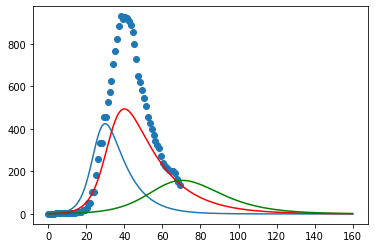

In [25]:
fig, ax = plt.subplots()
ax.plot(t, tf.squeeze(model_x(prior, horizon=days)))
ax.plot(t, tf.squeeze(model_x(model.weights[0], horizon=days)), color='r')
ax.plot(t, tf.squeeze(raw), color='g')
ax.scatter(t[:70], tf.squeeze(y))

In [26]:
model.weights

[<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.28452402],
        [0.05705406]], dtype=float32)>]

### Task 3: Perform epidemic prediction, find params that won't exceed health system capacity

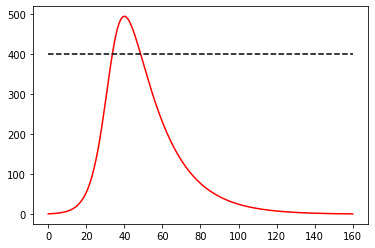

In [28]:
fig, ax = plt.subplots()
health_sys_cap = 400
ax.plot(t, tf.squeeze(model_x(model.weights[0], horizon=days)), color='r')
ax.plot(t, [health_sys_cap for _ in t], '--k')

In [ ]:
...

Ellipsis

### Task 4: Considering lockdown level for that time estimate restrictions beta value, propose 3 other lockdown methods and assume their beta level (e.g. curfew)

In [ ]:
...

Ellipsis